# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [195]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from lightgbm import LGBMRegressor

In [196]:
data = pd.read_csv('/datasets/autos.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


In [197]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Данные представлены в 16 колонках и 354369 строках. Из них прокуски обнаружены в следующих колонках: `VehicleType, Gearbox, Model, FuelType, NotRepaired`. К этих колонках записаны категориальные признаки.

Удалим столбцы, которые не несут полезной информации для построения моделей (`DateCrawled, RegistrationMonth, DateCreated, LastSeen`)

In [198]:
data = data.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'LastSeen', 'PostalCode'], axis=1)
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,NumberOfPictures
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN,0
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes,0
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN,0
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,0
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,0


Начнем с признака `NotRepaired` отвечающего за то,  не была ли машина в ремонте.

In [199]:
print('Количество пропусков: ', data['NotRepaired'].isna().sum())

Количество пропусков:  71154


Пропусков много и просто выкинуть эти строки не выйдет. Проверим распределение по категориям.

In [200]:
data['NotRepaired'].value_counts()

no     247161
yes     36054
Name: NotRepaired, dtype: int64

Судя по всему большинство автомобилей не были в ремонте. Примем допущение, что люди при заполнении данных не всегда указывают о том, что машина не была в ремонте, так как не считают это необходимым, тогда как люди с "битыми" машинами сообщают об этом. Поэтому заполним пропуска значениями "no".

In [201]:
data['NotRepaired'] = data['NotRepaired'].fillna('no')
print('Количество пропусков: ', data['NotRepaired'].isna().sum())

Количество пропусков:  0


Заполним все оставшиеся пропуски значением "no data".

In [202]:
data = data.fillna('no data')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 11 columns):
Price               354369 non-null int64
VehicleType         354369 non-null object
RegistrationYear    354369 non-null int64
Gearbox             354369 non-null object
Power               354369 non-null int64
Model               354369 non-null object
Kilometer           354369 non-null int64
FuelType            354369 non-null object
Brand               354369 non-null object
NotRepaired         354369 non-null object
NumberOfPictures    354369 non-null int64
dtypes: int64(5), object(6)
memory usage: 29.7+ MB


In [203]:
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,NumberOfPictures
0,480,no data,1993,manual,0,golf,150000,petrol,volkswagen,no,0
1,18300,coupe,2011,manual,190,no data,125000,gasoline,audi,yes,0
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,no,0
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,0
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,0


<div class="alert alert-block alert-success">
<b>Успех:</b> Заполнить пропуски таким образом – допустимое и достаточно безопасное решение.
</div>

Избавимся от объектов в нулевой ценой.

In [204]:
print('Цена равна 0:', data.query('Price == 0')['Price'].count())
data = data.query('Price != 0')
print('Цена равна 0:', data.query('Price == 0')['Price'].count())

Цена равна 0: 10772
Цена равна 0: 0


Построим распределение цены по количетву объявлений.

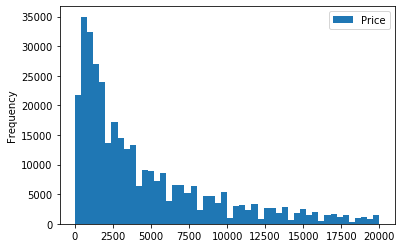

In [205]:
data.plot(y='Price', kind='hist', bins=50)

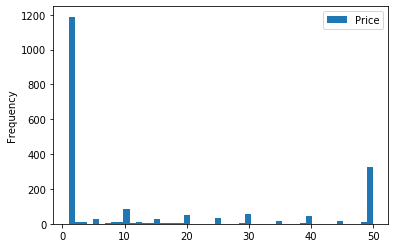

In [206]:
data.query('Price <= 50').plot(y='Price', kind='hist', bins=50)

Избавимся от объектов с ценой меньше 50 евро.

In [207]:
print('Цена меньше 50 евро:', data.query('Price < 50')['Price'].count())
data = data.query('Price >= 50')
print('Цена меньше 50 евро:', data.query('Price < 50')['Price'].count())

Цена меньше 50 евро: 1651
Цена меньше 50 евро: 0


Построим диаграмму с усами, чтобы понять какие года регистрации указывали в объявлениях.

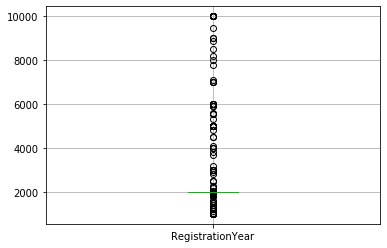

In [208]:
data.boxplot('RegistrationYear')

Присутствует много странных значений. Перестроим диаграмму на года с 1900 по 2021.

(1920, 2021)

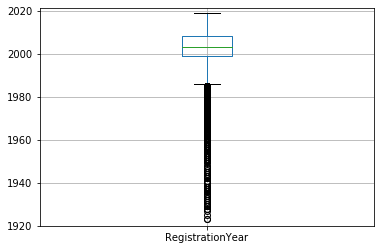

In [209]:
data.boxplot('RegistrationYear')
plt.ylim([1920, 2021])

Оставим объекты зарегистрированные после 1980.

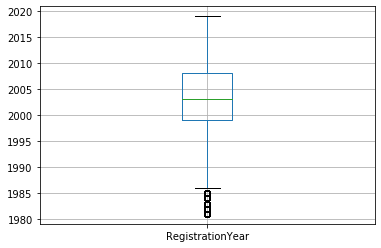

In [210]:
data = data.query('2020 > RegistrationYear > 1980')
data.boxplot('RegistrationYear')

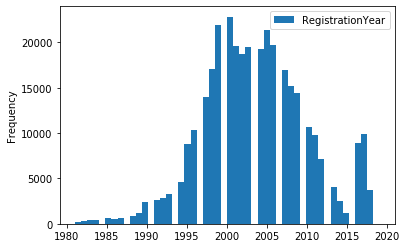

In [211]:
data.query('1920 < RegistrationYear < 2021').plot(y='RegistrationYear', kind='hist', bins=50)

Проверим пробег.

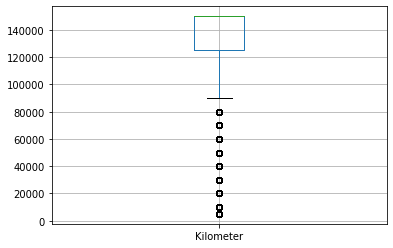

In [212]:
data.boxplot('Kilometer')

Колонка с пробегом в обработке не нуждается.

Для того, чтобы обучить модели нужно закодировать категориальные признаки. Для этого выберем метод OrdinalEncoding, так как OHE создает много признаков, из-за которых модель будет работать медленнее.

In [213]:
cat = ['VehicleType', 'RegistrationYear', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
encoder = OrdinalEncoder(dtype='int32')
encoder.fit(data[cat])
df = data.copy()
df[cat] = encoder.transform(data[cat])
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,NumberOfPictures
0,480,3,12,1,0,116,150000,7,38,0,0
1,18300,2,30,1,190,161,125000,2,1,1,0
2,9800,7,23,0,163,117,125000,2,14,0,0
3,1500,6,20,1,75,116,150000,7,38,0,0
4,3600,6,27,1,69,101,90000,2,31,0,0


In [214]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 338312 entries, 0 to 354368
Data columns (total 11 columns):
Price               338312 non-null int64
VehicleType         338312 non-null int64
RegistrationYear    338312 non-null int64
Gearbox             338312 non-null int64
Power               338312 non-null int64
Model               338312 non-null int64
Kilometer           338312 non-null int64
FuelType            338312 non-null int64
Brand               338312 non-null int64
NotRepaired         338312 non-null int64
NumberOfPictures    338312 non-null int64
dtypes: int64(11)
memory usage: 31.0 MB


Проверим не является ли NumberOfPictures константным признаком и если является, то удалим его.

In [215]:
df['NumberOfPictures'].value_counts()

0    338312
Name: NumberOfPictures, dtype: int64

In [216]:
df = df.drop('NumberOfPictures', axis=1)
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,3,12,1,0,116,150000,7,38,0
1,18300,2,30,1,190,161,125000,2,1,1
2,9800,7,23,0,163,117,125000,2,14,0
3,1500,6,20,1,75,116,150000,7,38,0
4,3600,6,27,1,69,101,90000,2,31,0


Разделим данные на признаки и целевой признак.

In [217]:
target = df['Price']
features = df.drop('Price', axis=1)

In [218]:
rnd = 123

Теперь разделим на обучающую и тестовую выборки.

In [219]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, random_state=rnd, test_size=0.2)

In [220]:
print(features.shape)
features_train.shape

(338312, 9)


(270649, 9)

In [221]:
print(target.shape)
target_train.shape

(338312,)


(270649,)

Числовые признаки отмасштабируем.

In [222]:
features_train.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
106488,8,22,1,150,11,150000,2,2,0
31490,6,16,1,73,128,125000,7,10,0
46410,8,25,1,101,101,50000,7,31,0
39128,5,26,1,105,42,60000,7,24,0
283751,5,25,1,80,116,125000,7,38,0


### Вывод

В этом разделе была произведена обработка данных:
    
    - Были удалены столбцы, не нужные для обучения моделей (DateCrawled, RegistrationMonth, DateCreated, LastSeen)
    - Были заполнены пропуски значениями "no" в столбце NotRepaired и "no data" в остальных
    - Были удалены объекты со значением в столбце Price меньше 50 евро
    - В столбце RegistrationYear были оставлены объекты с годом регестрации в диапазоне от 1980 до 2020
    - Категоральные признаки были закодированы методом OrdinalEncoding
    - Числовые признаки были отмасштабированы

## Обучение моделей

Напишем функцию которая будет нашей метрикой качества RMSE.

In [223]:
def rmse(target, pred):
    return mean_squared_error(target, pred) ** 0.5

In [224]:
rmse_score = make_scorer(rmse, greater_is_better=False)

### DecisionTree

In [225]:
depth_best = 0
score_best = 100000
for depth in range(1, 10):
    tree = DecisionTreeRegressor(random_state=rnd, max_depth=depth)
    score = abs(cross_val_score(tree, features_train, target_train, cv=3, scoring=rmse_score).mean())
    if score < score_best:
        depth_best = depth
        score_best = score
        tree_best = tree

print('Глубина:', depth_best)
print('RMSE:', score_best)

Глубина: 9
RMSE: 2046.2159788902375


### LinearRegression

In [226]:
lin = LinearRegression()
score_best = abs(cross_val_score(lin, features_train, target_train, cv=3, scoring=rmse_score).mean())
print('RMSE:', score_best)

RMSE: 3418.179954242276


### RandomForest

In [227]:
depth_best = 0
score_best = 100000
for depth in range(6, 10):
    forest = RandomForestRegressor(random_state=rnd, n_estimators=10, max_depth=depth)
    score = abs(cross_val_score(forest, features_train, target_train, cv=3, scoring=rmse_score).mean())
    if score < score_best:
        depth_best = depth
        score_best = score
            
print('Глубина:', depth_best)
print('RMSE:', score_best)

Глубина: 9
RMSE: 1968.8929099071995


In [228]:
score_best = 100000
est_best = 0
for est in range(10, 50, 10):
    forest = RandomForestRegressor(random_state=rnd, n_estimators=est, max_depth=depth_best)
    score = abs(cross_val_score(forest, features_train, target_train, cv=3, scoring=rmse_score).mean())
    if score < score_best:
        score_best = score
        est_best = est
        forest_best = forest

print('Количество деревьев:', est_best)
print('RMSE:', score_best)

Количество деревьев: 40
RMSE: 1960.837680569856


### LGBMRegressor

In [229]:
cat = ['VehicleType', 'RegistrationYear', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
for i in cat:
    features_train[i] = features_train[i].astype('category')
    features_test[i] = features_test[i].astype('category')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [230]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 270649 entries, 106488 to 261171
Data columns (total 9 columns):
VehicleType         270649 non-null category
RegistrationYear    270649 non-null category
Gearbox             270649 non-null category
Power               270649 non-null int64
Model               270649 non-null category
Kilometer           270649 non-null int64
FuelType            270649 non-null category
Brand               270649 non-null category
NotRepaired         270649 non-null category
dtypes: category(7), int64(2)
memory usage: 8.3 MB


In [231]:
depth_best = 0
score_best = 100000
for depth in range(6, 11):
    lgbm = LGBMRegressor(random_state=rnd, max_depth=depth)
    score = abs(cross_val_score(lgbm, features_train, target_train, cv=2, scoring=rmse_score).mean())
    if score < score_best:
        depth_best = depth
        score_best = score
            
print('Глубина:', depth_best)
print('RMSE:', score_best)

Глубина: 10
RMSE: 1633.4577388587763


In [232]:
score_best = 100000
est_best = 0
for est in range(100, 300, 50):
    lgbm = LGBMRegressor(random_state=rnd, n_estimators=est, max_depth=depth_best)
    score = abs(cross_val_score(lgbm, features_train, target_train, cv=2, scoring=rmse_score).mean())
    if score < score_best:
        score_best = score
        est_best = est

print('Количество деревьев:', est_best)
print('RMSE:', score_best)

Количество деревьев: 250
RMSE: 1587.2507165353768


In [233]:
score_best = 100000
rate_best = 0
for rate in np.arange(0.1, 0.6, 0.1):
    lgbm = LGBMRegressor(
        random_state=rnd, n_estimators=est_best, max_depth=depth_best, learning_rate=rate)
    score = abs(cross_val_score(lgbm, features_train, target_train, cv=2, scoring=rmse_score).mean())
    if score < score_best:
        score_best = score
        rate_best = rate
        lgbm_best = lgbm

print('Learning rate:', rate_best)
print('RMSE:', score_best)


Learning rate: 0.2
RMSE: 1578.0936341184668


### Вывод

В этом разделе были обучены модели DecisionTree, LinearRegression, RandomForest, LGBMRegressor и были определены гиперпараметры, при которых метрика качетсва RMSE наименьшая. По результатам обучения можно сказать, что LGBMRegressor показывает самый лучших результат по качеству.

## Анализ моделей

Сравним показатели качества и времени работы различных моделей на тестовой выборке.

### DecisionTree

In [234]:
cur_time = dt.datetime.now()

tree_best.fit(features_train, target_train)
learning_time = (dt.datetime.now() - cur_time).total_seconds()

cur_time = dt.datetime.now()
predictions = tree_best.predict(features_test)
predict_time = (dt.datetime.now() - cur_time).total_seconds()
rmse_s = rmse(target_test, predictions)
print('RMSE:', rmse_s)
print('Время обучения:', learning_time, 'секунд')
print('Время предсказывания:', predict_time, 'секунд')

tr = {
    'Name': 'DecisionTree',
    'RMSE': rmse_s,
    'Learning time': learning_time,
    'Predictions time': predict_time
}

RMSE: 2034.8089001333349
Время обучения: 0.631892 секунд
Время предсказывания: 0.02927 секунд


### LinearRegression

In [235]:
cur_time = dt.datetime.now()

lin.fit(features_train, target_train)
learning_time = (dt.datetime.now() - cur_time).total_seconds()

cur_time = dt.datetime.now()
predictions = lin.predict(features_test)
predict_time = (dt.datetime.now() - cur_time).total_seconds()
rmse_s = rmse(target_test, predictions)
print('RMSE:', rmse_s)
print('Время обучения:', learning_time, 'секунд')
print('Время предсказывания:', predict_time, 'секунд')

ln = {
    'Name': 'LinearRegression',
    'RMSE': rmse_s,
    'Learning time': learning_time,
    'Predictions time': predict_time
}

RMSE: 3433.946898393174
Время обучения: 0.158119 секунд
Время предсказывания: 0.071239 секунд


### RandomForest

In [236]:
cur_time = dt.datetime.now()

forest_best.fit(features_train, target_train)
learning_time = (dt.datetime.now() - cur_time).total_seconds()

cur_time = dt.datetime.now()
predictions = forest_best.predict(features_test)
predict_time = (dt.datetime.now() - cur_time).total_seconds()
rmse_s = rmse(target_test, predictions)
print('RMSE:', rmse_s)
print('Время обучения:', learning_time, 'секунд')
print('Время предсказывания:', predict_time, 'секунд')

fr = {
    'Name': 'RandomForest',
    'RMSE': rmse_s,
    'Learning time': learning_time,
    'Predictions time': predict_time
}

RMSE: 1963.5302514094699
Время обучения: 15.287021 секунд
Время предсказывания: 0.212234 секунд


### LGBMRegressor

In [237]:
cur_time = dt.datetime.now()

lgbm_best.fit(features_train, target_train)
learning_time = (dt.datetime.now() - cur_time).total_seconds()

cur_time = dt.datetime.now()
predictions = lgbm_best.predict(features_test)
predict_time = (dt.datetime.now() - cur_time).total_seconds()
rmse_s = rmse(target_test, predictions)
print('RMSE:', rmse_s)
print('Время обучения:', learning_time, 'секунд')
print('Время предсказывания:', predict_time, 'секунд')

lg = {
    'Name': 'LGBMRegressor',
    'RMSE': rmse_s,
    'Learning time': learning_time,
    'Predictions time': predict_time
}

RMSE: 1550.1393845371429
Время обучения: 16.893664 секунд
Время предсказывания: 1.206856 секунд


Объединим полученные данные в таблицу

In [238]:
columns = ['Name', 'RMSE', 'Learning time', 'Predictions time']
final = pd.DataFrame([tr, ln, fr, lg], columns=columns)
final

,Name,RMSE,Learning time,Predictions time
0,DecisionTree,2034.808900,0.631892,0.029270
1,LinearRegression,3433.946898,0.158119,0.071239
2,RandomForest,1963.530251,15.287021,0.212234
3,LGBMRegressor,1550.139385,16.893664,1.206856


Отсортируем таблицу по убыванию качества.

In [239]:
final.sort_values('RMSE', ascending=True)

,Name,RMSE,Learning time,Predictions time
3,LGBMRegressor,1550.139385,16.893664,1.206856
2,RandomForest,1963.530251,15.287021,0.212234
0,DecisionTree,2034.808900,0.631892,0.029270
1,LinearRegression,3433.946898,0.158119,0.071239


Как можно заметить лучшая по качеству модель LGBMRegressor обучается и предсказывает дольше остальных, но время предсказания равное 1.2 секунде, говорит о том, что предсказывание происходит хоть и медленнее остальных моделей, но все равно быстро.

Проверим модели на адекватность обучив DummyRegressor.

In [240]:
%%time

dummy = DummyRegressor()
dummy.fit(features_train, target_train)
predictions = dummy.predict(features_test)
print('RMSE:', rmse(target_test, predictions))

RMSE: 4509.476057749606
CPU times: user 3.88 ms, sys: 3 µs, total: 3.88 ms
Wall time: 2.81 ms


Все модели показали метрику RMSE лучше, чем DummyRegressor, что означет, что все прошли проверку на адекватность.

### Вывод

В этом разделе был произведен анализ работы моделей на тестовой выборке и оценка на адекватность. Все модели прошли проверку на адекватность на DummyRegressor. Лучшей по времени предсказания себя показала модель DecisionTree, а худшей LGBMRegressor. По времени обучения LinearRegression - лучшая, а LGBMRegressor - худшая. По качеству все наоборот: LGBMRegressor - лучшая, а LinearRegression - худшая. Оптимальной для онлайн сервиса была выбрана модель LGBMRegressor, так как она существенно качественнее остальных моделей, а время предсказаний у нее хоть и самое большое, но все еще низкое.